#### Generate EMG recordings using neuromotion through `muniverse`

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
from muniverse.data_generation import generate_recording

# Define the configuration file path and output directory
config_path = '../configs/neuromotion.json'
output_dir = '../outputs'

run_dir = generate_recording({
    'input_config': config_path,
    'output_dir': output_dir,
    'engine': 'singularity',
    'container': os.path.abspath('../environment/muniverse-test_neuromotion.sif')
})

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

In [3]:
data_path = Path('/rds/general/user/pm1222/ephemeral/muniverse/datasets/outputs/neuromotion-test/todo')
run_dirs = [d for d in data_path.iterdir() if d.is_dir() and d.name.startswith('run_')]

In [4]:
def load_run_data(run_dir):
    """
    Load NPZ files and metadata from a run directory.
    
    Args:
        run_dir: Path to the run directory
        
    Returns:
        dict: Dictionary containing:
            - angle_profile: numpy array of angle profile
            - effort_profile: numpy array of effort profile
            - emg: numpy array of EMG data
            - spikes: numpy array of spikes data
            - metadata: dictionary of metadata
    """
    # Find all required files
    angle_files = list(run_dir.glob('*angle_profile.npz'))
    effort_files = list(run_dir.glob('*effort_profile.npz'))
    emg_files = list(run_dir.glob('*emg.npz'))
    spike_files = list(run_dir.glob('*spikes.npz'))
    metadata_files = list(run_dir.glob('*_log.json'))
    
    if not all([angle_files, effort_files, emg_files, metadata_files]):
        print(f"Missing required files in {run_dir}")
        return None
    
    try:
        # Load NPZ files
        angle_data = np.load(angle_files[0], allow_pickle=True)
        effort_data = np.load(effort_files[0], allow_pickle=True)
        emg_data = np.load(emg_files[0], allow_pickle=True)
        spike_data = np.load(spike_files[0], allow_pickle=True)
        # Load metadata
        with open(metadata_files[0], 'r') as f:
            metadata = json.load(f)
        
        return {
            'angle_profile': angle_data['angle_profile'],
            'effort_profile': effort_data['effort_profile'],
            'emg': emg_data['emg'],
            'spikes': spike_data['spikes'],
            'metadata': metadata
        }
    except Exception as e:
        print(f"Error loading data from {run_dir}: {str(e)}")
        return None

In [34]:
# results = load_run_data(np.random.choice(run_dirs, replace=False))
results = load_run_data(run_dirs[4])
# results = load_run_data(Path('/rds/general/user/pm1222/ephemeral/muniverse/datasets/outputs/neuromotion-test/run_20250507_005852'))

In [ ]:
results['metadata']['InputData']['Configuration']['MovementConfiguration']

In [ ]:
fs = results['metadata']['InputData']['Configuration']['RecordingConfiguration']['SamplingFrequency']
duration = results['metadata']['InputData']['Configuration']['MovementConfiguration']['MovementProfileParameters']['MovementDuration']
time = np.linspace(0, duration, fs*duration)

fig, ax1 = plt.subplots(figsize=(5, 3))
ax2 = ax1.twinx()
ax1.plot(time, results['angle_profile'], c='C0', label='angle')
ax2.plot(time, results['effort_profile'], c='C1', label='effort')

In [ ]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.eventplot(results['spikes'][::2], linelengths=0.5, linewidths=0.2);
plt.subplot(1, 2, 2)
plt.plot(time, results['emg'][:, np.random.randint(0, results['emg'].shape[1], size=10)], linewidth=0.1);

In [9]:
from muniverse.data_preparation.data2bids import bids_neuromotion_recording

In [50]:
recording = bids_neuromotion_recording(
    subject=1,
    task='FDSIisometricflexionsinusoid40percentmvc',
    root='/rds/general/user/pm1222/ephemeral/muniverse/datasets/',
    datatype='emg',
    datasetname='neuromotion-test',
    session=1,
    run=1,
)

In [51]:
recording.read()

In [68]:
emg_edf = recording.emg_data

In [25]:
import edfio

In [69]:
n_channels = emg_edf.num_signals
emg_data = np.stack([emg_edf.signals[i].data for i in range(n_channels)])

In [ ]:
plt.plot(emg_data[np.random.randint(0, results['emg'].shape[1], size=10)].T, linewidth=0.1);

Optionally, (1) format the data into BIDS structure, and (2)upload them to harvard dataverse

In [3]:
from muniverse.utils import bidsify_data

data_path = run_dir
root = '../'
datasetname = 'neuromotion-dev'
bidsdata = bidsify_data.neuromotion_to_bids(data_path, root, datasetname)

In [ ]:
from muniverse.utils.dataverse import DataverseUploader

DATAVERSE_URL = "https://dataverse.harvard.edu"
API_TOKEN = "854b1bff-c5da-474c-86ea-1d3bb83c046d"

# Initialize the uploader
uploader = DataverseUploader(
    api_token=API_TOKEN,
    dataverse_url=DATAVERSE_URL,
    dataverse_alias="muniverse-datasets",
)

In [2]:
datasets = uploader.list_datasets()

In [ ]:
datasets[-1]

In [4]:
uploader.set_dataset(datasets[-1]['persistentUrl'])

In [ ]:
registry = uploader.upload_directory(
    local_directory="/rds/general/user/pm1222/ephemeral/muniverse/datasets/neuromotion-test/",
    remote_base_directory="neuromotion-test",
    dry_run=False
)

In [90]:
import edfio
import scipy
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
root = '/rds/general/user/pm1222/ephemeral/muniverse/datasets/bids/Grison_et_al_2025'
sub = 'sub-01'
mvc = 15
task = f'isometric{mvc}percentmvc'
sig = edfio.read_edf(os.path.join(root, f'{sub}/emg/{sub}_task-{task}_run-01_emg.edf'))
inst = pd.read_csv(os.path.join(root, f'{sub}/emg/{sub}_task-{task}_run-01_channels.tab'), delimiter='\t')
path_idx = inst.query('description.str.lower() == "requested path"').index[0]
idx = np.where(np.diff(sig.signals[path_idx].data == mvc) == 1)[0]

In [166]:
from pathlib import Path

In [162]:
edf_path = os.path.join(root, f'{sub}/emg/{sub}_task-{task}_run-01_emg.edf')

In [163]:
edf_path

'/rds/general/user/pm1222/ephemeral/muniverse/datasets/bids/Grison_et_al_2025/sub-01/emg/sub-01_task-isometric15percentmvc_run-01_emg.edf'

In [167]:
mvc = int(Path(edf_path).stem.split('_')[-1].split('mvc')[0])

ValueError: invalid literal for int() with base 10: 'emg'

In [157]:
inst[inst['type'].str.startswith('EMG')]['sampling_frequency'].iloc[0]

np.float64(10240.0)

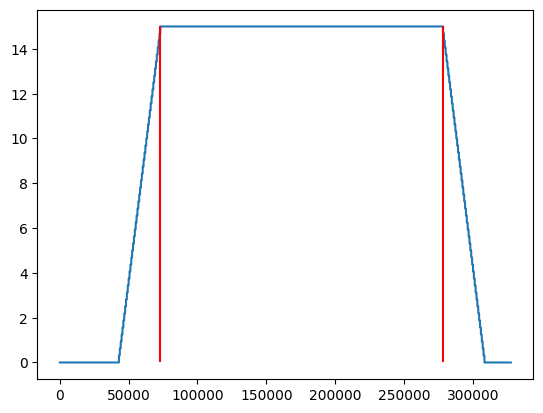

In [153]:
plt.plot(sig.signals[path_idx].data)
plt.vlines(idx, 0, mvc, color='r')
plt.show()


In [2]:
import os
import json
import pandas as pd
from pathlib import Path

def extract_bids_components(filename):
    """Extract subject and task from BIDS filename."""
    parts = filename.split('_')
    subject = parts[0]  # e.g., 'sub-sim01'
    task = parts[2] if len(parts) > 2 else ''  # e.g., 'task-FDSIisometricflexionsinusoid40percentmvc'
    return subject, task

def create_bids_dataframe(bids_root):
    """Create a DataFrame containing all EDF files in the BIDS structure and their corresponding simulation log paths."""
    # Find all EDF files recursively
    edf_files = list(Path(bids_root).rglob('*_emg.edf'))
    
    # Create lists to store the data
    data = []
    
    for edf_path in edf_files:
        try:
            # Extract BIDS components
            subject, task = extract_bids_components(edf_path.stem)
            
            # Find corresponding simulation.json file
            sim_path = edf_path.parent / f"{edf_path.stem.replace('_emg', '')}_simulation.json"
            
            # Initialize row data
            row_data = {
                'edf_path': str(edf_path),
                'simulation_path': str(sim_path) if sim_path.exists() else None,
                'subject': subject,
                'task': task
            }
            
            # If simulation file exists, extract relevant fields
            if sim_path.exists():
                with open(sim_path, 'r') as f:
                    sim_data = json.load(f)
                    # Extract fields from simulation configuration
                    config = sim_data.get('InputData', {}).get('Configuration', {})
                    movement_config = config.get('MovementConfiguration', {})
                    profile_params = movement_config.get('MovementProfileParameters', {})
                    
                    # Add relevant fields to row data
                    row_data.update({
                        'target_muscle': movement_config.get('TargetMuscle'),
                        'movement_type': movement_config.get('MovementType'),
                        'movement_dof': movement_config.get('MovementDOF'),
                        'effort_profile': profile_params.get('EffortProfile'),
                        'effort_level': profile_params.get('EffortLevel'),
                        'movement_duration': profile_params.get('MovementDuration'),
                        'sampling_frequency': config.get('RecordingConfiguration', {}).get('SamplingFrequency'),
                        'noise_level': config.get('RecordingConfiguration', {}).get('NoiseLeveldb')
                    })
            
            data.append(row_data)
            
        except Exception as e:
            print(f"Warning: Error processing {edf_path.name} - {str(e)}")
            continue
    
    if not data:
        raise ValueError("No valid EDF files found in the BIDS structure")
    
    return pd.DataFrame(data)

In [3]:
# Example usage:
bids_root = '/rds/general/user/pm1222/ephemeral/muniverse/datasets/bids/neuromotion-test'  # Replace with your BIDS dataset path
df = create_bids_dataframe(bids_root)

# Display the first few rows
print(df.head())

# Display basic information about the dataset
print("\nDataset Info:")
print(f"Total number of recordings: {len(df)}")
print(f"Number of subjects: {df['subject'].nunique()}")
print(f"Number of tasks: {df['task'].nunique()}")
print(f"Number of recordings with simulation data: {df['simulation_path'].notna().sum()}")

                                            edf_path  \
0  /rds/general/user/pm1222/ephemeral/muniverse/d...   
1  /rds/general/user/pm1222/ephemeral/muniverse/d...   
2  /rds/general/user/pm1222/ephemeral/muniverse/d...   
3  /rds/general/user/pm1222/ephemeral/muniverse/d...   
4  /rds/general/user/pm1222/ephemeral/muniverse/d...   

                                     simulation_path    subject  \
0  /rds/general/user/pm1222/ephemeral/muniverse/d...  sub-sim02   
1  /rds/general/user/pm1222/ephemeral/muniverse/d...  sub-sim02   
2  /rds/general/user/pm1222/ephemeral/muniverse/d...  sub-sim02   
3  /rds/general/user/pm1222/ephemeral/muniverse/d...  sub-sim02   
4  /rds/general/user/pm1222/ephemeral/muniverse/d...  sub-sim02   

                                            task target_muscle movement_type  \
0  task-PLisometricflexiontriangular32percentmvc            PL     Isometric   
1   task-ECUisometricradialtrapezoid64percentmvc           ECU     Isometric   
2   task-FDSIisometr

In [9]:
import matplotlib.pyplot as plt

In [11]:
df['target_muscle'].value_counts()

target_muscle
ECRB     185
ECRL     159
FCU      156
FDSI     133
PL       127
EDI      103
ECU       97
FCU_u     25
Name: count, dtype: int64